# counts of pcqtl signals

* Fraction of clusters with a signal
* number of credible sets
* number of unique credibles sets
    * grouped by lead varaint
    * grouped by colocalizaion
* broken down by correlation in cluster

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
import scipy as sp
from scipy.stats import linregress, chisquare, ttest_rel, ranksums


import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *


In [ ]:
# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

In [3]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

In [ ]:
pc_susie = load_across_tissues(config, load_pc_susie)
e_susie = load_across_tissues(config, load_e_susie)

pc_susie_r = load_across_tissues(config, load_pc_susie_r)
e_susie_r = load_across_tissues(config, load_e_susie_r)

clusters = load_across_tissues(config, load_clusters_annotated)

In [5]:
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))
tissue_pal

[(0.7215686274509804, 0.22745098039215686, 0.29411764705882354),
 (0.7667820069204152, 0.3172318339100346, 0.26440599769319495),
 (0.81199538638985, 0.40701268742791236, 0.23469434832756633),
 (0.859361783929258, 0.5010688196847367, 0.20356785851595538),
 (0.9045751633986928, 0.5908496732026144, 0.1738562091503268),
 (0.9497885428681276, 0.6806305267204922, 0.1441445597846982),
 (0.993756247597078, 0.7722106881968474, 0.11650903498654364),
 (0.8962245290272972, 0.758000768935025, 0.23341791618608226),
 (0.7986928104575164, 0.7437908496732026, 0.3503267973856209),
 (0.6965167243367936, 0.7289042675893888, 0.4728027681660899),
 (0.5989850057670127, 0.7146943483275663, 0.5897116493656285),
 (0.5014532871972318, 0.7004844290657439, 0.7066205305651673),
 (0.403921568627451, 0.6862745098039216, 0.8235294117647058)]

In [ ]:
#TODO add pair coloc goruping to cluster counts

In [6]:
def get_cluster_counts(tissue_df, clusters, pc_susie, e_susie):
    cs_counts_df = pd.DataFrame({'tissue':tissue_df['Tissue'], 
                       'num_clusters':[sum(clusters['tissue_id'] == t) for t in tissue_df['Tissue']],
                       'num_pc_clusters':[pc_susie[pc_susie['tissue_id'] == t]['cluster_id'].nunique() for t in tissue_df['Tissue']],
                        'num_e_clusters':[e_susie[e_susie['tissue_id'] == t]['cluster_id'].nunique() for t in tissue_df['Tissue']],})
    cs_counts_df['percent_e_clusters'] = cs_counts_df['num_e_clusters']/ cs_counts_df['num_clusters'] * 100
    cs_counts_df['percent_pc_clusters'] = cs_counts_df['num_pc_clusters']/ cs_counts_df['num_clusters'] * 100


    # e and pcqtl signals in each  by lead var
    combined_susie = pd.concat([e_susie, pc_susie], names=['type', 'idx'], keys=['eQTL', 'pcQTL']).reset_index(drop=0).drop(columns=['idx'])
    credible_sets = combined_susie.groupby(['cs_id', 'tissue_id', 'cluster_id']).agg({'type':'first', 'lead_variant_id':'first'}).reset_index()
    # add lead var overlap information
    lead_var_grouped = credible_sets.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 'type':list})
    lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
    lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
    lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'Shared', 'eQTL only'), 'pcQTL only')
    credible_sets = lead_var_grouped.explode(['cs_id', 'type'])
    credible_sets['has_pcqtl'] = credible_sets['num_pc_samelead'] > 0

    # number of credible sets over tissues
    cs_counts_df['num_eqtl_credible_sets'] = credible_sets[credible_sets['type']=='eQTL'].groupby('tissue_id').agg({'cs_id':'nunique'}).values
    cs_counts_df['num_pcqtl_credible_sets'] = credible_sets[credible_sets['type']=='pcQTL'].groupby('tissue_id').agg({'cs_id':'nunique'}).values

    # num credible sets wtih multiple signals
    cs_counts_df['num_multiple_eqtl_credible_sets'] = credible_sets[(credible_sets['type']=='eQTL')&(credible_sets['num_e_samelead']>1)].groupby('tissue_id').agg({'cs_id':'nunique'}).values
    cs_counts_df['num_multiple_pcqtl_credible_sets'] = credible_sets[(credible_sets['type']=='pcQTL')&(credible_sets['num_pc_samelead']>1)].groupby('tissue_id').agg({'cs_id':'nunique'}).values

    # unique credible sets by lead var
    deduplicated_lead_vars = credible_sets['type'].reset_index().drop_duplicates()
    cs_counts_df['num_unique_eqtl_credible_sets'] = deduplicated_lead_vars[(deduplicated_lead_vars['type']=='eQTL')].groupby('tissue_id').agg({'lead_variant_id':'nunique'}).values
    cs_counts_df['num_unique_pcqtl_credible_sets'] = deduplicated_lead_vars[(deduplicated_lead_vars['type']=='pcQTL')].groupby('tissue_id').agg({'lead_variant_id':'nunique'}).values

    return cs_counts_df

In [9]:
cs_counts_df = get_cluster_counts(tissue_df, clusters, pc_susie_r, e_susie_r)
# fraction in each
print('e:{}'.format(cs_counts_df['num_e_clusters'].sum()/cs_counts_df['num_clusters'].sum()))
print('pc:{}'.format(cs_counts_df['num_pc_clusters'].sum()/cs_counts_df['num_clusters'].sum()))
print(ttest_rel(cs_counts_df['num_eqtl_credible_sets'], cs_counts_df['num_pcqtl_credible_sets']))

e:0.6803360505739477
pc:0.6656130427549493
TtestResult(statistic=9.429816551976113, pvalue=6.727966809434659e-07, df=12)


In [10]:
cs_counts_old_df = get_cluster_counts(tissue_df, clusters, pc_susie, e_susie)
# fraction in each
print('e:{}'.format(cs_counts_old_df['num_e_clusters'].sum()/cs_counts_old_df['num_clusters'].sum()))
print('pc:{}'.format(cs_counts_old_df['num_pc_clusters'].sum()/cs_counts_old_df['num_clusters'].sum()))
print(ttest_rel(cs_counts_old_df['num_eqtl_credible_sets'], cs_counts_old_df['num_pcqtl_credible_sets']))

e:0.716353352187656
pc:0.7024621527200133
TtestResult(statistic=5.820009806661017, pvalue=8.21274353478906e-05, df=12)


### Number clusters with signal

/local/scratch/klawren/slrmtmp.46850341/ipykernel_37010/137747467.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


TtestResult(statistic=5.931590669640099, pvalue=6.907039062209438e-05, df=12)

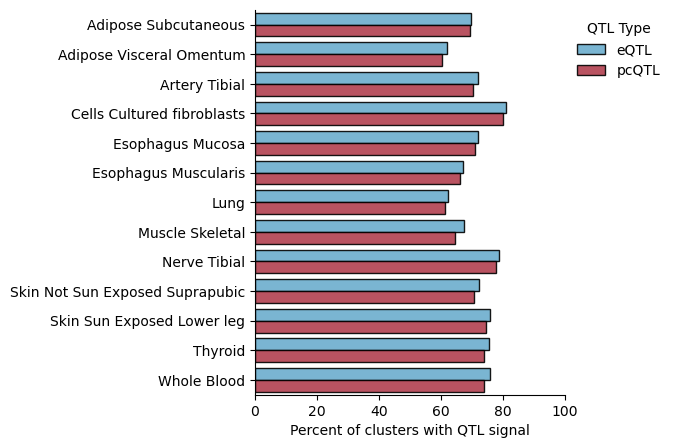

In [51]:
melted = cs_counts_df.melt(id_vars='tissue', value_vars=['percent_e_clusters', 'percent_pc_clusters'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(4,5))

sns.barplot(melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'percent_e_clusters':'#67AFD2', 'percent_pc_clusters':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['eQTL', 'pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

ax.set_ylabel('')
ax.set_xlabel('Percent of clusters with QTL signal')
ax.set_xlim(0,100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

/local/scratch/klawren/slrmtmp.46850341/ipykernel_37010/4254894928.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=5.931590669640099, pvalue=6.907039062209438e-05, df=12)

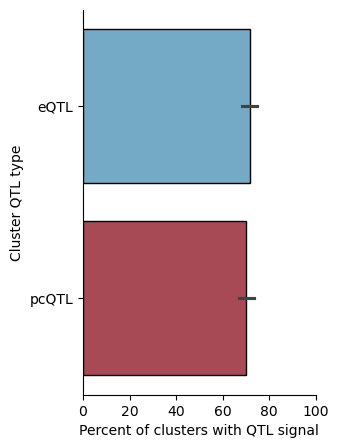

In [52]:
fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'percent_e_clusters':'#67AFD2', 'percent_pc_clusters':'#B83A4B'})

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Percent of clusters with QTL signal')
ax.set_xlim(0,100)
ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

### number credible sets (total)

/local/scratch/klawren/slrmtmp.46850341/ipykernel_37010/868750570.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


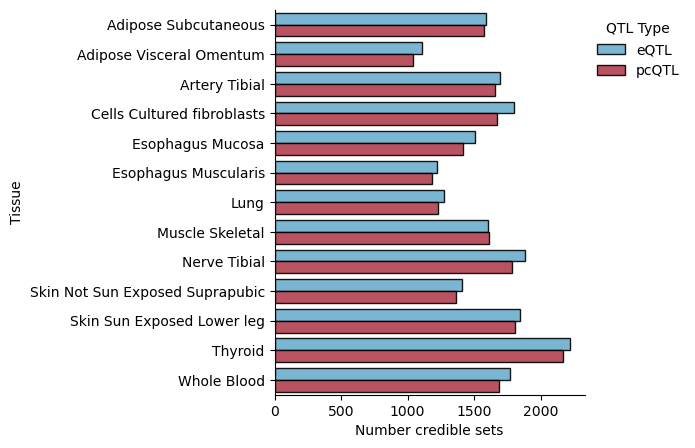

In [ ]:
cs_melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_eqtl_credible_sets', 'num_pcqtl_credible_sets'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(cs_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'num_eqtl_credible_sets':'#67AFD2', 'num_pcqtl_credible_sets':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number credible sets')
ax.set_ylabel('Tissue')

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['eQTL', 'pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
plt.gca().get_legend().set_frame_on(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()


/local/scratch/klawren/slrmtmp.46850341/ipykernel_37010/1827559213.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=5.931590669640099, pvalue=6.907039062209438e-05, df=12)

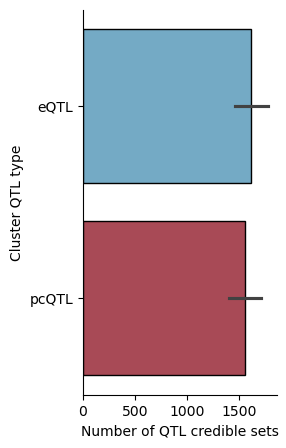

In [50]:
fig, ax = plt.subplots(figsize=(2.5,5))
sns.barplot(cs_melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'num_eqtl_credible_sets':'#67AFD2', 'num_pcqtl_credible_sets':'#B83A4B'})


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')
ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

### number credible sets with shared lead var

In [ ]:
# # e and pcqtl signals in each  by lead var
# combined_susie = pd.concat([e_susie, pc_susie], names=['type', 'idx'], keys=['eQTL', 'pcQTL']).reset_index(drop=0).drop(columns=['idx'])
# credible_sets = combined_susie.groupby(['cs_id', 'tissue_id', 'cluster_id']).agg({'type':'first', 'lead_variant_id':'first'}).reset_index()
# # add lead var overlap information
# lead_var_grouped = credible_sets.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 'type':list})
# lead_var_grouped['num_eqtl_samelead'] = lead_var_grouped['type'].astype(str).str.count('eQTL')
# lead_var_grouped['num_pcqtl_samelead'] = lead_var_grouped['type'].astype(str).str.count('pcQTL')
# lead_var_grouped['multiple_e'] = lead_var_grouped['num_eqtl_samelead'] > 1
# lead_var_grouped['multiple_pc'] = lead_var_grouped['num_pcqtl_samelead'] > 1
# lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
# lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
# lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'Shared', 'eQTL only'), 'pcQTL only')
# credible_sets = lead_var_grouped.explode(['cs_id', 'type'])
# credible_sets['has_pcqtl'] = credible_sets['num_pc_samelead'] > 0

/local/scratch/klawren/slrmtmp.46850341/ipykernel_37010/1698741091.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


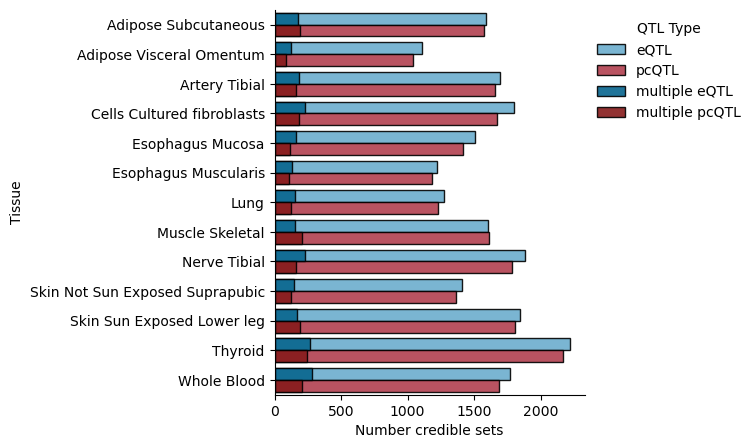

In [71]:
# the full amount
fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(cs_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'num_eqtl_credible_sets':'#67AFD2', 'num_pcqtl_credible_sets':'#B83A4B'}, order=tissue_ids)
# the multiple ones colored
multiple_melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_multiple_eqtl_credible_sets', 'num_multiple_pcqtl_credible_sets'], var_name='type', value_name='percent')
sns.barplot(multiple_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent',palette={'num_multiple_eqtl_credible_sets':'#016895', 'num_multiple_pcqtl_credible_sets':'#8C1515'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number credible sets')
ax.set_ylabel('Tissue')
leg = ax.get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['eQTL', 'pcQTL', 'multiple eQTL', 'multiple pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.gca().get_legend().set_frame_on(False)

plt.show()


/local/scratch/klawren/slrmtmp.46850341/ipykernel_37010/1039986243.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


Text(0.5, 0, 'Number of QTL credible sets')

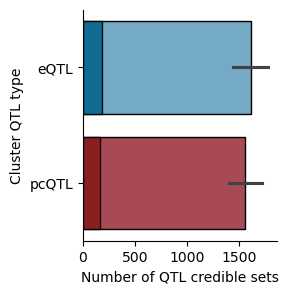

In [68]:
cs_melted['type_short'] = cs_melted['type'].str.split('_').str[1]
multiple_melted['type_short'] = multiple_melted['type'].str.split('_').str[2]

fig, ax = plt.subplots(figsize=(2.5,3))
sns.barplot(cs_melted, ax = ax, hue='type_short', y='type_short', x='percent', edgecolor='k', palette={'eqtl':'#67AFD2', 'pcqtl':'#B83A4B'})
sns.barplot(multiple_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type_short', y='type_short', x='percent',palette={'eqtl':'#016895', 'pcqtl':'#8C1515'}, errorbar=None)


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')

### number unique credible sets

/local/scratch/klawren/slrmtmp.46850341/ipykernel_37010/3688489747.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


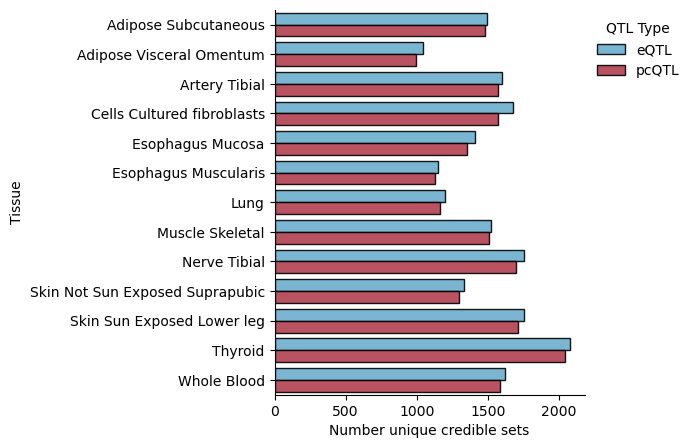

In [72]:
# combined for unique signals
lead_var_melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_unique_eqtl_credible_sets', 'num_unique_pcqtl_credible_sets'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(lead_var_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'num_unique_eqtl_credible_sets':'#67AFD2', 'num_unique_pcqtl_credible_sets':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number unique credible sets')
ax.set_ylabel('Tissue')
leg = ax.get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['eQTL', 'pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
plt.gca().get_legend().set_frame_on(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()


/local/scratch/klawren/slrmtmp.46850341/ipykernel_37010/3153081973.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=5.931590669640099, pvalue=6.907039062209438e-05, df=12)

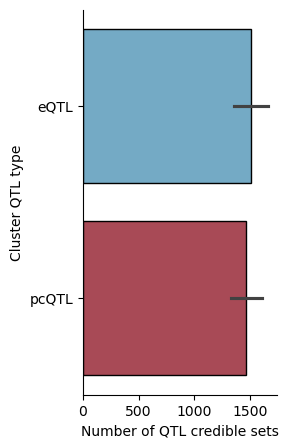

In [74]:
fig, ax = plt.subplots(figsize=(2.5,5))
sns.barplot(lead_var_melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'num_unique_eqtl_credible_sets':'#67AFD2', 'num_unique_pcqtl_credible_sets':'#B83A4B'})


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')
ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

## across cluster correlations

In [ ]:
cs_counts_df = get_cluster_counts(tissue_df, clusters, pc_susie, e_susie)


,tissue,num_clusters,num_pc_clusters,num_e_clusters,percent_e_clusters,percent_pc_clusters,num_eqtl_credible_sets,num_pcqtl_credible_sets,num_multiple_eqtl_credible_sets,num_multiple_pcqtl_credible_sets,num_unique_eqtl_credible_sets,num_unique_pcqtl_credible_sets
0,Adipose_Subcutaneous,992,689,690,69.556452,69.455645,1588,1578,173,189,1494,1482
1,Adipose_Visceral_Omentum,851,513,528,62.044653,60.282021,1107,1043,127,86,1040,996
2,Artery_Tibial,964,677,692,71.784232,70.228216,1698,1654,184,160,1599,1571
3,Cells_Cultured_fibroblasts,861,689,698,81.068525,80.023229,1799,1672,229,187,1674,1574
4,Esophagus_Mucosa,883,626,635,71.913930,70.894677,1504,1420,165,114,1410,1356
5,Esophagus_Muscularis,787,520,527,66.963151,66.073698,1223,1184,131,112,1151,1125
6,Lung,947,579,589,62.196410,61.140444,1277,1229,152,121,1198,1162
7,Muscle_Skeletal,1072,691,724,67.537313,64.458955,1607,1610,155,205,1524,1507
8,Nerve_Tibial,886,689,698,78.781038,77.765237,1886,1787,229,164,1754,1699
9,Skin_Not_Sun_Exposed_Suprapubic,815,577,588,72.147239,70.797546,1411,1362,143,124,1333,1299


### with R susie instead of tensorqtl susie

In [ ]:
pc_susie = load_across_tissues(config, load_pc_susie_r)
e_susie = load_across_tissues(config, load_e_susie_r)
clusters = load_across_tissues(config, load_cluster)

In [ ]:
clusters = load_across_tissues(config, load_clusters_annotated)

In [ ]:
clusters['has_eqtl'] = clusters['cluster_id'].isin(deduplicated_lead_vars[deduplicated_lead_vars['type']=='eQTL']['cluster_id'])
clusters['has_pcqtl'] = clusters['cluster_id'].isin(deduplicated_lead_vars[deduplicated_lead_vars['type']=='pcQTL']['cluster_id'])

In [ ]:
from scipy.stats import chi2_contingency

# Observed counts
contingency_table = [clusters['has_pcqtl'].value_counts().values, clusters['has_eqtl'].value_counts().values]
print(contingency_table)
# Perform the Chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2_stat}, p-value: {p_value}, Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

[array([1796,  373]), array([1764,  405])]
Chi-squared Statistic: 1.5051623292221483, p-value: 0.21987875861221784, Degrees of Freedom: 1
Expected Frequencies: 
[[1780.  389.]
 [1780.  389.]]


In [ ]:
### look across correlation bins for the number of unique signals and if theres a pc vs eqtl difference

In [ ]:
# combine signals with coloc not lead var